In [1]:
import torch
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd

import laia.data.transforms as transforms

from laia.common.loader import ModelLoader, CheckpointLoader
from laia.data import ImageDataLoader, TextImageFromTextTableDataset
from laia.utils import SymbolsTable, ImageToTensor
from laia.experiments import Experiment
from laia.engine.feeders import ImageFeeder, ItemFeeder
from laia.decoders import CTCGreedyDecoder

from tqdm import tqdm

In [2]:
!export CUDA_VISIBLE_DEVICES=1

In [3]:
reg = 'reg07'

In [4]:
syms = SymbolsTable('../exper/puigcerver17_transfer_bn_dist/train/syms_ctc.txt')
device = torch.device('cuda:1')

train_path = '../exper/puigcerver17_transfer_bn_dist/train/'
model_filename = 'model'
checkpoint_filename = 'experiment.ckpt.lowest-valid-cer-31'
gt_path = '../data/sommarioni/fake_'+reg+'_text.txt'
image_path = '../data/sommarioni/'+reg+'/patch_prepared_h128'
result_csv = '../data/sommarioni/'+reg+'/patches_'+reg+'.csv'

In [5]:
from os import listdir
from os.path import isfile, join
imgs_path=image_path
imgs = [f for f in tqdm(listdir(imgs_path)) if isfile(join(imgs_path, f))]
output = ''
for file in tqdm(imgs):
    file_id = file.split('.')[0]
    output += file_id + ' fake\n'

f = open(gt_path, "wt")
f.write(output)
f.close()

100%|██████████| 7711/7711 [00:00<00:00, 521573.94it/s]


In [6]:
model = ModelLoader(
        train_path, filename=model_filename, device=device
    ).load()
state = CheckpointLoader(device=device).load_by(
        os.path.join(train_path, checkpoint_filename)
    )
if 'tr_engine' in state:
    state = Experiment.get_model_state_dict(state)
model.load_state_dict(state)
model = model.to(device)
model.eval()

LaiaCRNN(
  (conv): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.01)
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.01)
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): Leak

In [7]:
dataset = TextImageFromTextTableDataset(
    gt_path,
    image_path,
    img_transform=ImageToTensor(),
    txt_transform=transforms.text.ToTensor(syms),
)
dataset_loader = ImageDataLoader(
    dataset=dataset,
    image_channels=1,
    batch_size=10,
    num_workers=8,
)
batch_input_fn = ImageFeeder(device=device, parent_feeder=ItemFeeder("img"))
batch_target_fn = ItemFeeder("txt")
batch_id_fn = ItemFeeder("id")
decoder = CTCGreedyDecoder()

In [8]:
decoded = []
ids = []

counter = 0

# Go through all the samples, compute the prediction, get the label
for batch in tqdm(dataset_loader):
    batch_input = batch_input_fn(batch)
    
    batch_id = batch_id_fn(batch)
    batch_input = batch_input_fn(batch)
    
    #print(batch['id'])
    
    batch_output = model(batch_input)
    batch_decoded = decoder(batch_output)

    decoded.extend(batch_decoded)
    ids.extend(batch_id)
decoded = [[syms[char] for char in entry] for entry in decoded]
result = pd.DataFrame(zip(ids, decoded), columns=['id', 'decoded']).set_index('id')

100%|██████████| 772/772 [00:27<00:00, 27.73it/s]


In [9]:
def res2clean(res):
    return "".join(res).replace('@', ' ')
def show_result(result_row):
    img_path = os.path.join(image_path, result_row.name + ".jpg")
    decoded = res2clean(result_row['decoded'])
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.imread(img_path)[:,:,::-1])
    print(f'Prediction is "{decoded}"')

In [10]:
result['cleaned'] = result['decoded'].map(res2clean)
result.drop(['decoded'], axis=1).to_csv(result_csv)
result

,decoded,cleaned
id,,
Censo-stabile_Sommarioni-napoleonici_reg-07_0069_065_1754_1981_5900_6503_1_6,[],
Censo-stabile_Sommarioni-napoleonici_reg-07_0069_065_1452_1545_5900_6519_1_5,[],
Censo-stabile_Sommarioni-napoleonici_reg-07_0069_065_770_869_5900_6553_2_2,[],
Censo-stabile_Sommarioni-napoleonici_reg-07_0069_065_2433_2518_5900_6489_1_9,[],
Censo-stabile_Sommarioni-napoleonici_reg-07_0069_065_1115_1203_5900_6550_1_3,[],
...,...,...
Censo-stabile_Sommarioni-napoleonici_reg-07_0068_064_765_959_1218_1358_1_1,"[1, @, 3, g, a]",1 3ga
Censo-stabile_Sommarioni-napoleonici_reg-07_0068_064_790_963_1101_1242_1_1,"[d, e, t, t, à]",dettà
Censo-stabile_Sommarioni-napoleonici_reg-07_0068_064_5088_5170_1053_1179_1_5,[],


In [11]:
idx = 0

Prediction is ""


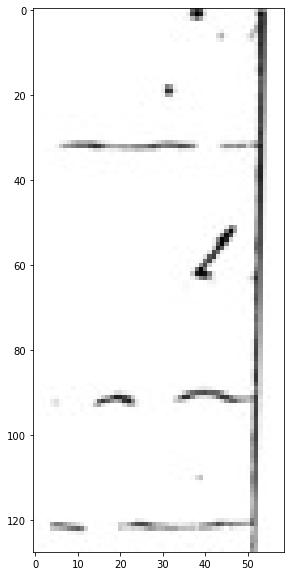

In [12]:
show_result(result.iloc[idx])
idx += 1